In [12]:
import pandas as pd
DATA_PATH = "../data/Formula_1/"
results = pd.read_csv(DATA_PATH + "results.csv")
races = pd.read_csv(DATA_PATH + "races.csv")
drivers = pd.read_csv(DATA_PATH + "drivers.csv")
constructors = pd.read_csv(DATA_PATH + "constructors.csv")
# Load additional files
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")
driver_standings = pd.read_csv(DATA_PATH + "driver_standings.csv")
constructor_standings = pd.read_csv(DATA_PATH + "constructor_standings.csv")



In [13]:
# 🎯 Create target variable: 1 = Podium finish (Top 3), 0 = No podium
results['podium'] = results['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# 🧪 Check the distribution of the target
podium_counts = results['podium'].value_counts(normalize=True)
print("Podium target distribution:")
print(podium_counts)


Podium target distribution:
podium
0    0.873052
1    0.126948
Name: proportion, dtype: float64


In [14]:
# 🔗 Merge results with races to get race metadata
merged = results.merge(
    races[['raceId', 'year', 'circuitId', 'date']],
    on='raceId',
    how='left'
)

# 🔗 Merge with drivers to get driver info
merged = merged.merge(
    drivers[['driverId', 'driverRef', 'nationality']],
    on='driverId',
    how='left'
)

# 🔗 Merge with constructors to get team info
merged = merged.merge(
    constructors[['constructorId', 'name']],
    on='constructorId',
    how='left'
)

# 🔄 Rename for clarity
merged = merged.rename(columns={'name': 'constructor_name'})

# 🧪 Preview result
merged[['raceId', 'driverRef', 'constructor_name', 'grid', 'positionOrder', 'podium', 'year']].head()

# Merge qualifying (best position per driver/race)
qualifying_min = qualifying.groupby(['raceId', 'driverId'])[['position']].min().reset_index()
qualifying_min = qualifying_min.rename(columns={'position': 'qualifying_position'})
merged = merged.merge(qualifying_min, on=['raceId', 'driverId'], how='left')

# Merge driver standings
driver_standings_latest = driver_standings.groupby(['raceId', 'driverId'])[['points']].max().reset_index()
driver_standings_latest = driver_standings_latest.rename(columns={'points': 'driver_points'})
merged = merged.merge(driver_standings_latest, on=['raceId', 'driverId'], how='left')

# Merge constructor standings
constructor_standings_latest = constructor_standings.groupby(['raceId', 'constructorId'])[['points']].max().reset_index()
constructor_standings_latest = constructor_standings_latest.rename(columns={'points': 'constructor_points'})
merged = merged.merge(constructor_standings_latest, on=['raceId', 'constructorId'], how='left')


In [15]:
# 🧠 Select relevant features for ML
model_data = merged[[
    'grid',
    'constructor_name',
    'driverRef',
    'year',
    'qualifying_position',
    'driver_points',
    'constructor_points',
    'podium'
]].dropna()


# 🧪 Check shape
print("Shape before encoding:", model_data.shape)

# 🔤 Encode categorical variables using one-hot encoding
model_data_encoded = pd.get_dummies(
    model_data,
    columns=['constructor_name', 'driverRef', 'year'],
    drop_first=True
)

# 🧪 Check shape after encoding
print("Shape after encoding:", model_data_encoded.shape)

# 👀 Preview encoded features
model_data_encoded.head()


Shape before encoding: (10251, 8)
Shape after encoding: (10251, 249)


,grid,qualifying_position,driver_points,constructor_points,podium,constructor_name_AlphaTauri,constructor_name_Alpine F1 Team,constructor_name_Arrows,constructor_name_Aston Martin,constructor_name_BAR,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,1,1.0,10.0,14.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,5,5.0,8.0,8.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,7,7.0,6.0,9.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11,12.0,5.0,5.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3,3.0,4.0,14.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 🎯 Split features (X) and target (y)
X = model_data_encoded.drop('podium', axis=1)
y = model_data_encoded['podium']

# 🔁 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🌲 Train Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 📈 Predict
y_pred = clf.predict(X_test)

# 🧾 Evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1754
           1       0.65      0.49      0.56       297

    accuracy                           0.89      2051
   macro avg       0.78      0.72      0.75      2051
weighted avg       0.88      0.89      0.88      2051

Confusion Matrix:

[[1674   80]
 [ 150  147]]


C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\2339582327.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(20), x='Importance', y='Feature', palette='viridis')


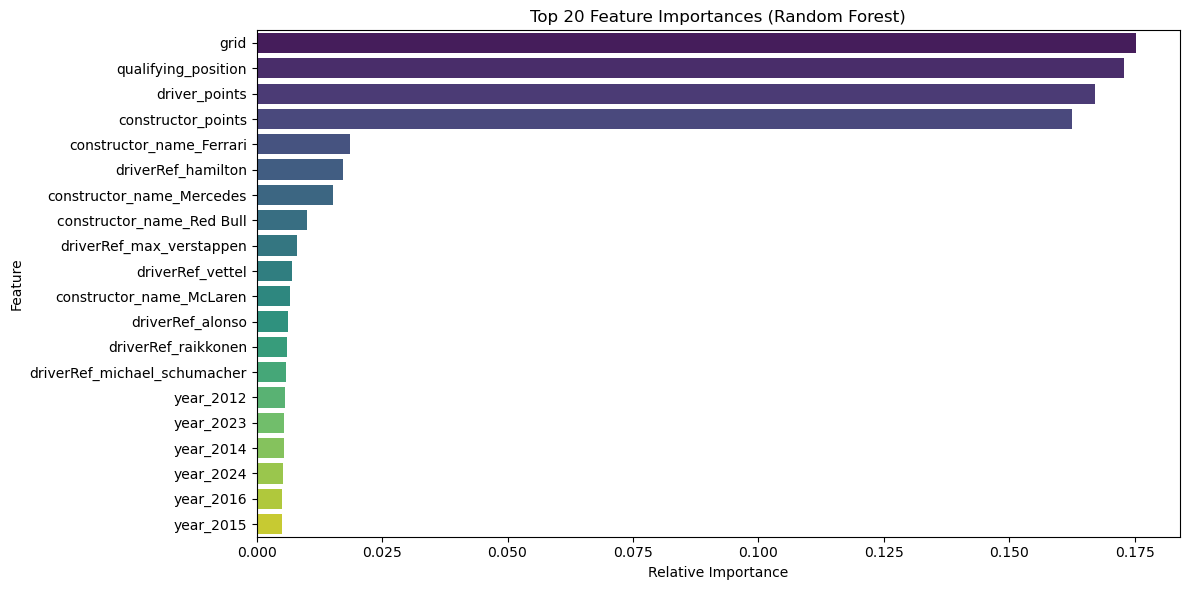

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔍 Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# 📦 Put into a DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 📊 Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.linear_model import LogisticRegression

# ⚙️ Create and train model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# 🧠 Predict and evaluate
y_pred_log = logreg.predict(X_test)

print("🔎 Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_log))


🔎 Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1754
           1       0.69      0.52      0.59       297

    accuracy                           0.90      2051
   macro avg       0.80      0.74      0.76      2051
weighted avg       0.89      0.90      0.89      2051



c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
from xgboost import XGBClassifier

# ⚙️ Create and train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# 🧠 Predict and evaluate
y_pred_xgb = xgb.predict(X_test)

print("🚀 XGBoost Classifier Report:\n")
print(classification_report(y_test, y_pred_xgb))


c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:35:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🚀 XGBoost Classifier Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1754
           1       0.67      0.54      0.60       297

    accuracy                           0.89      2051
   macro avg       0.80      0.75      0.77      2051
weighted avg       0.89      0.89      0.89      2051



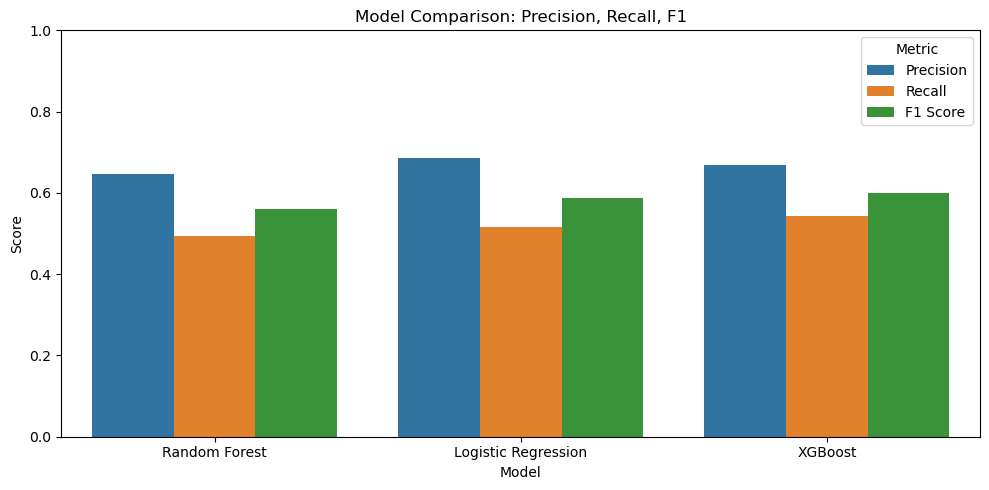

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Collect scores
scores = []

# Random Forest
scores.append({
    'Model': 'Random Forest',
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
})

# Logistic Regression
scores.append({
    'Model': 'Logistic Regression',
    'Precision': precision_score(y_test, y_pred_log),
    'Recall': recall_score(y_test, y_pred_log),
    'F1 Score': f1_score(y_test, y_pred_log)
})

# XGBoost
scores.append({
    'Model': 'XGBoost',
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb)
})

# 📦 Convert to DataFrame
score_df = pd.DataFrame(scores)

# Melt for plotting
score_df_melted = score_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# 📊 Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=score_df_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison: Precision, Recall, F1")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\987775620.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_df.head(20), x='Importance', y='Feature', palette='crest')


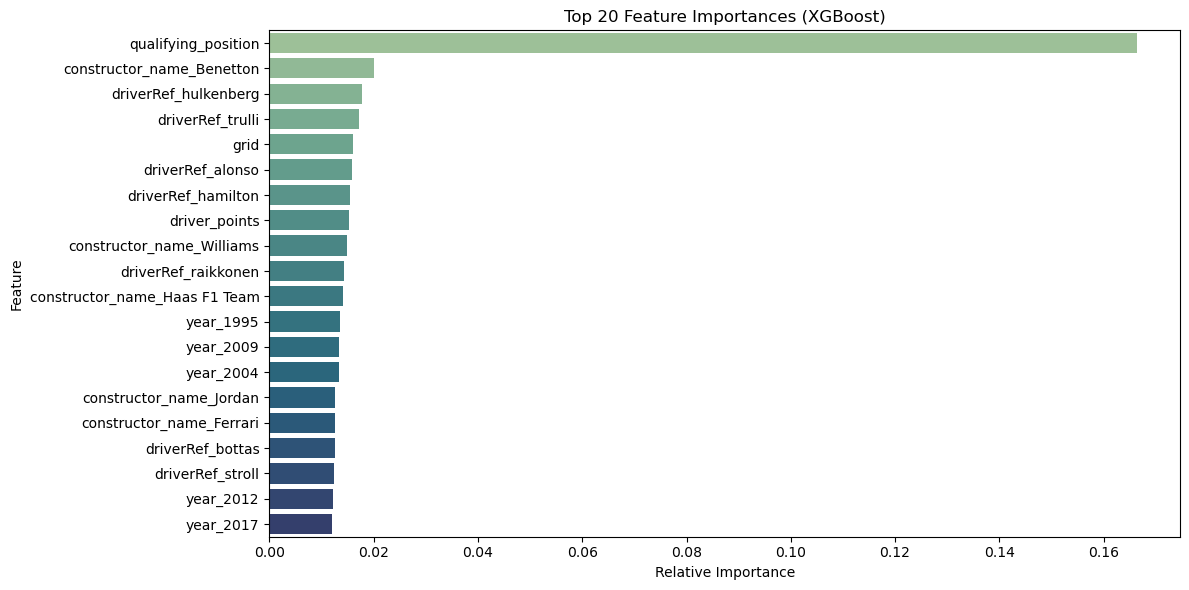

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 🔍 Extract feature importances from XGBoost
xgb_importances = xgb.feature_importances_
feature_names = X.columns

# 📦 Build DataFrame
xgb_feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# 📊 Plot top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_feat_df.head(20), x='Importance', y='Feature', palette='crest')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


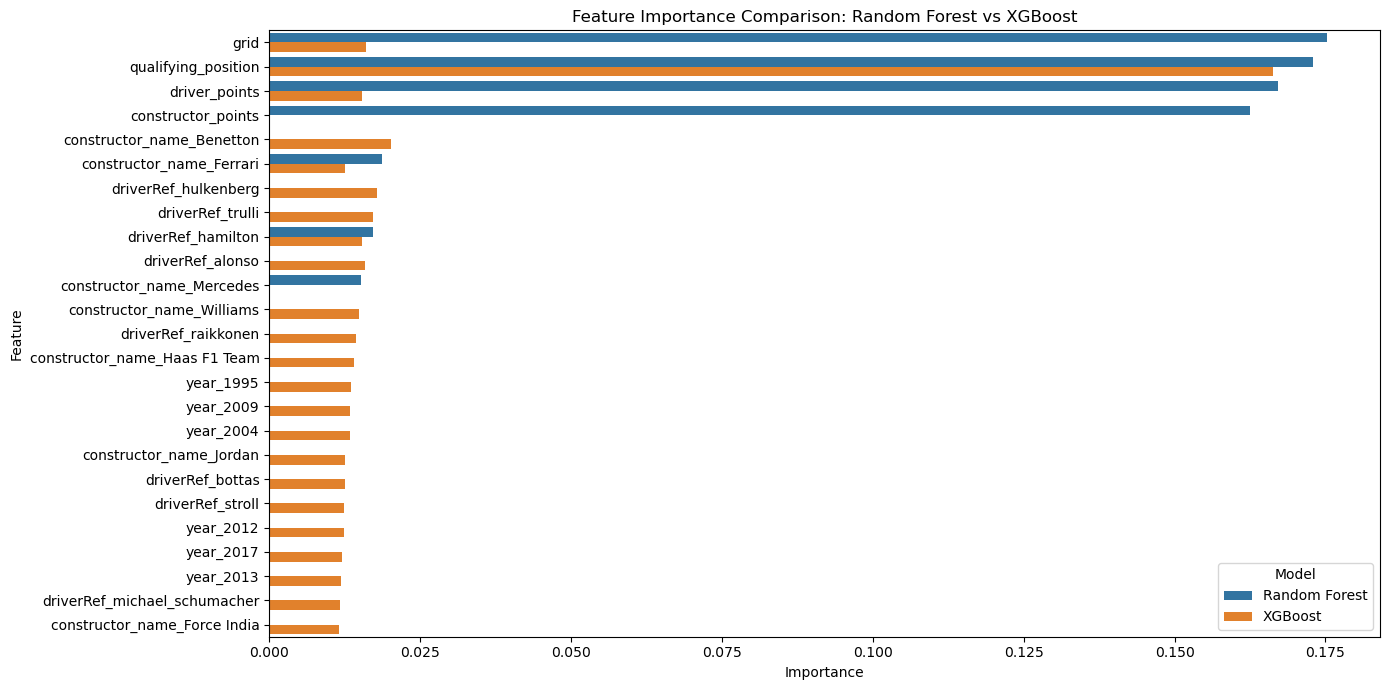

In [22]:
# 📊 Get feature importances from both models
rf_importances = clf.feature_importances_
xgb_importances = xgb.feature_importances_

# 📦 Create combined DataFrame
feat_compare_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances
})

# 📐 Melt for seaborn
feat_compare_melted = feat_compare_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# 📊 Plot side-by-side
plt.figure(figsize=(14, 7))
sns.barplot(
    data=feat_compare_melted.sort_values(by='Importance', ascending=False).head(30),
    x='Importance',
    y='Feature',
    hue='Model'
)
plt.title("Feature Importance Comparison: Random Forest vs XGBoost")
plt.tight_layout()
plt.show()
